## Import libraries

In [125]:
import numpy as np 
import pandas as pd
import os
import zipfile
import cv2
from matplotlib import pyplot as plt
import shutil 
from tqdm import tqdm
import torch
import torchvision
import time
import copy
from torchvision import transforms, models

# in case CUDA is not available, shutdown notebook and reload GPU in terminal:
#     sudo rmmod nvidia_uvm
#     sudo modprobe nvidia_uvm

## Extract data

In [126]:
print(os.listdir('input'),'\n') 
with zipfile.ZipFile('input/platesv2/plates.zip', 'r') as zip_obj:
        zip_obj.extractall('img/') 
print(os.listdir('img/'))

data_root = 'img/plates/' 
print(data_root)
print(os.listdir(data_root))

['platesv2'] 

['__MACOSX', 'plates']
img/plates/
['test', '.DS_Store', 'train']


## Split data into train and val

In [127]:
train_dir = 'train' # на этих данных будем обучать модель
val_dir = 'val' #на этих данных будем смотреть какую accuracy показывает наша модель 
class_names = ['cleaned', 'dirty']
 
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
 
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5768.58it/s]


## Data processing

In [128]:
train_transforms_base = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms_rotate_augment = transforms.Compose([
    transforms.ColorJitter(hue=(-0.5,-0.3)),
    transforms.RandomRotation(degrees = 150),
    transforms.RandomResizedCrop(224, scale=(0.65, 0.9), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms_flip_augment = transforms.Compose([
    transforms.ColorJitter(hue=(-0.5,-0.3)),
    transforms.RandomResizedCrop(224, scale=(0.65, 0.9), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees = 150),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset_base = torchvision.datasets.ImageFolder(train_dir, train_transforms_base)
train_dataset_rotated = torchvision.datasets.ImageFolder(train_dir, train_transforms_rotate_augment)
train_dataset_flipped = torchvision.datasets.ImageFolder(train_dir, train_transforms_flip_augment)
val_dataset_base = torchvision.datasets.ImageFolder(val_dir, val_transforms_base)
val_dataset_augmented = torchvision.datasets.ImageFolder(val_dir, val_transforms_augmented)

train_dataset = torch.utils.data.ConcatDataset([train_dataset_base, train_dataset_rotated, train_dataset_flipped])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_base])


batch_size = 16 # Количество изображений в батче
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

## Output images

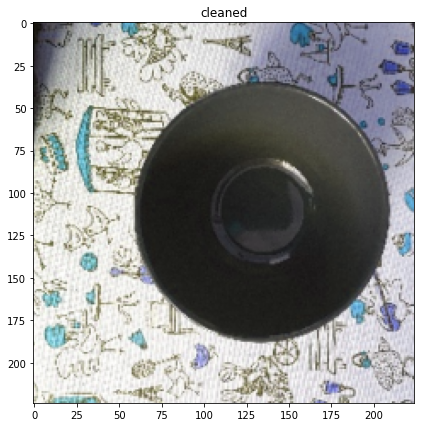

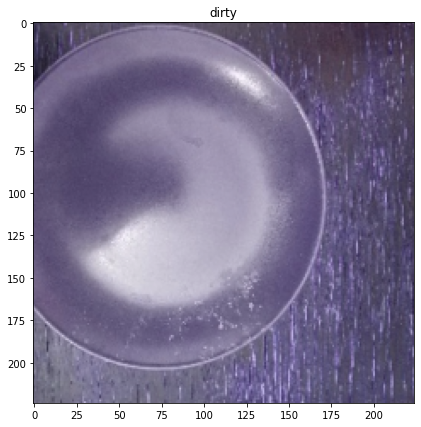

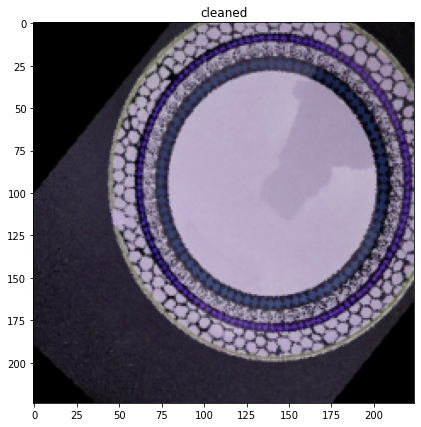

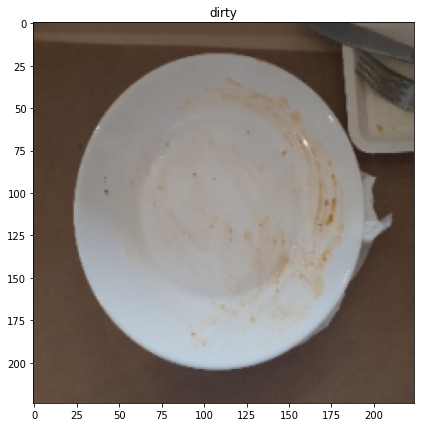

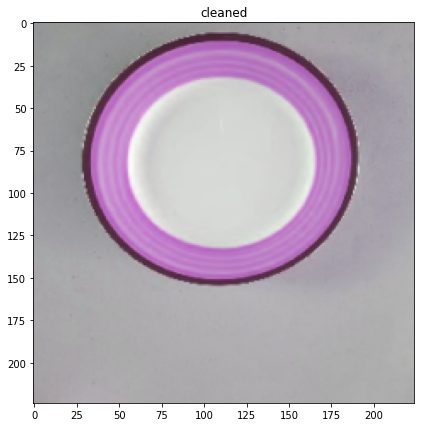

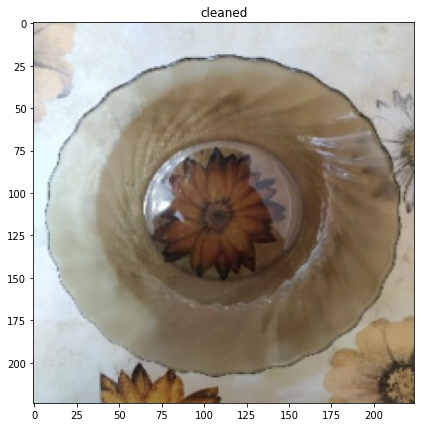

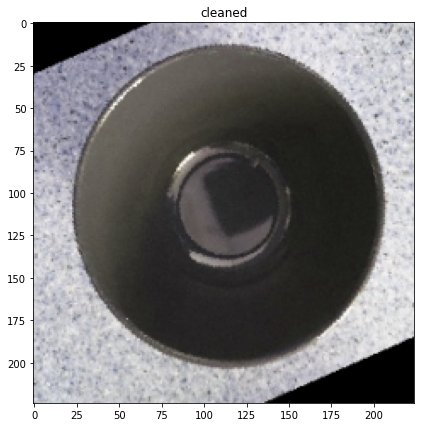

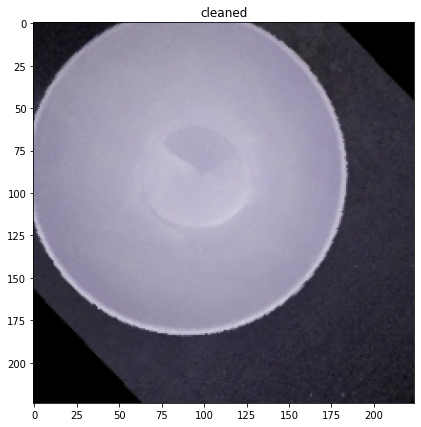

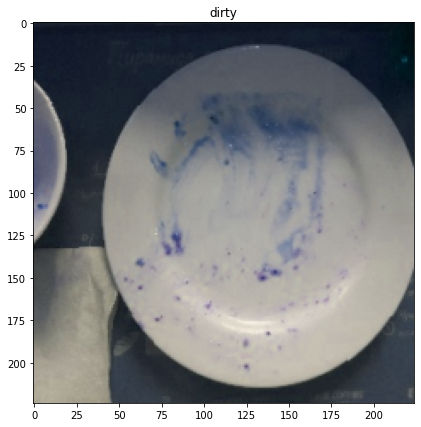

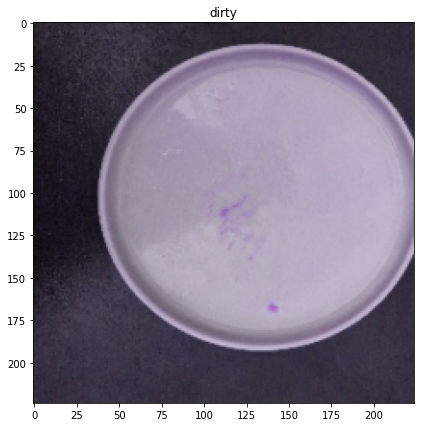

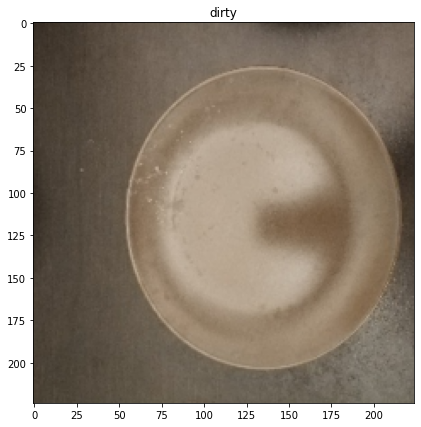

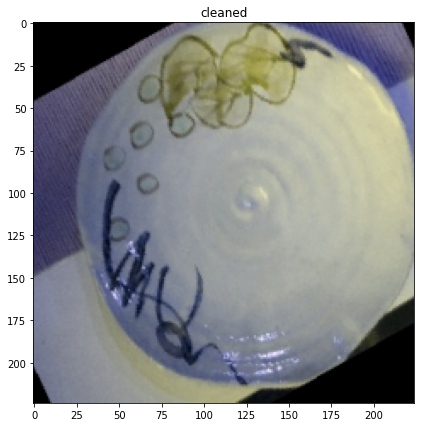

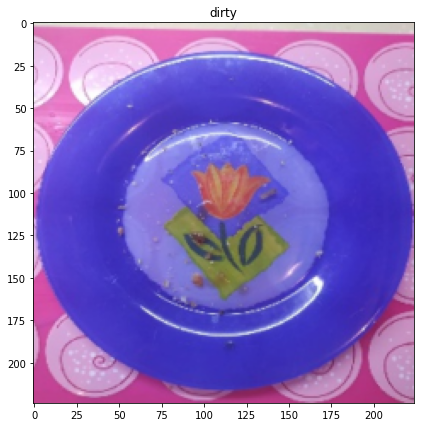

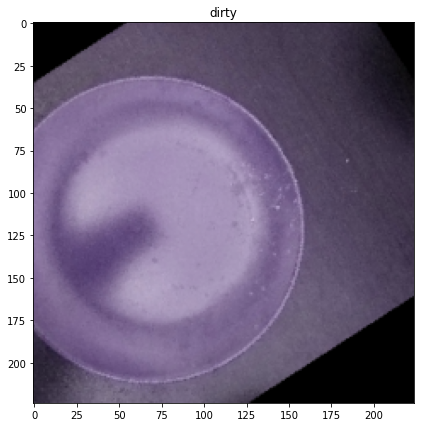

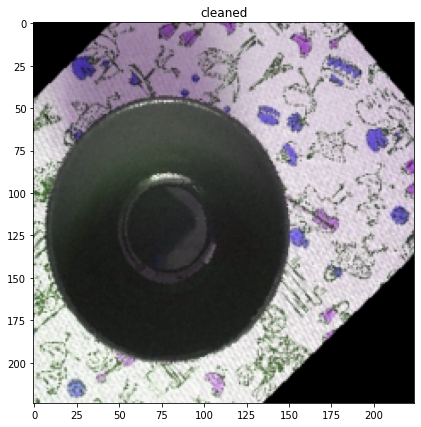

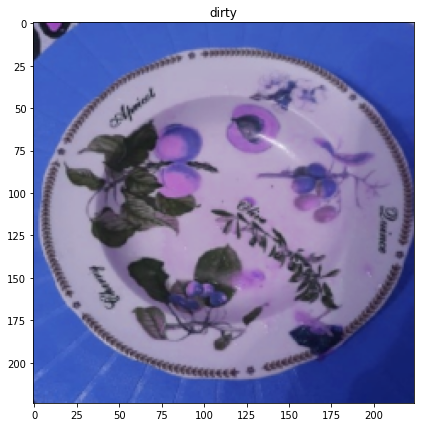

In [129]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy() #обратная операция к ToTensor - .permute(1, 2, 0) Channels,H,W -> H,W,Channels потом превращаем в numpy array .numpy()
    image = std * image + mean #Делаем обратную трансформацию нормировки
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.1)
 
X_batch, y_batch = next(iter(train_dataloader)) 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

## Function to train the network

In [130]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
 
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
 
    for epoch in range(num_epochs):
        print("\n Epoch {}/{}:".format(epoch, num_epochs - 1), end="")
        for phase in ['train', 'val']:
            if phase == 'train': #Если фаза == Тренировки  
                dataloader = train_dataloader #берем train_dataLoader
                scheduler.step() #Делаем 1 шаг (произошла одна эпоха)
                model.train()  # Модель в training mode - обучение (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
            else: #Если фаза == Валидации 
                dataloader = val_dataloader #берем val_dataLoader 
                model.eval()   # Модель в evaluate mode - валидация (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
 
            running_loss = 0. 
            running_acc = 0.
 
            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) # Тензор с изображениями переводим на GPU 
                labels = labels.to(device) # Тензор с лейблами переводим на GPU 
 
                optimizer.zero_grad() # Обнуляем градиент,чтобы он не накапливался 
 
                with torch.set_grad_enabled(phase == 'train'): #Если фаза train то активируем все градиенты (те которые не заморожены) (очистить историю loss)
                    preds = model(inputs) # Считаем предикты, input передаем в модель
                    loss_value = loss(preds, labels) #Посчитали  Loss    
                    preds_class = preds.argmax(dim=1) # Получаем класс,берем .argmax(dim=1) нейрон с максимальной активацией
                
                    if phase == 'train':
                        loss_value.backward() # Считаем градиент 
                        optimizer.step() # Считаем шаг градиентного спуска
 
                # Статистика
                running_loss += loss_value.item() #считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  #считаем accuracy
 
            epoch_loss = running_loss / len(dataloader)  # Loss'ы делим на кол-во бачей в эпохе 
            epoch_acc = running_acc / len(dataloader) #считаем Loss на кол-во бачей в эпохе
 
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc), end="")
            
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)
        
    return model, loss_hist, acc_hist

## Network settings and parameters

In [131]:
model = models.resnet18(pretrained=True) #Формат pretrained=True - нам нужны веса, которые получились вследствие обучения этого ResNet, на датасете ImageNet
          
# Замораживаем веса, чтобы не использовать лишние веса в обучении, а обучать только последний слой
for param in model.parameters(): #Проходим по параметрам модели (каждый параметр - это каждый слой, model.parameters нам отдаст некоторый итератор по слоям)
   param.requires_grad = False #Для каждого параметра и слоя:"requires grad = False", то есть уже не требуется вычисление градиента для данного слоя. И получается, что у нас вся сетка будет заморожена, то есть мы не сможем вообще ничего обучать.
    
#Меняем последний полносвязанный слой, в ResNet он классифицирует на тысячу классов, а у нас класса всего 2.
model.fc = torch.nn.Linear(model.fc.in_features, 2) # Cоздадим слой torch.nn.Linear, это полносвязный слой, на вход он принимает model fc_in features. И он единсвенный - разморожен.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Network will be trained on {device} device")
model = model.to(device)
 
#Определяем Loss функцию
#В данном случае - это бинарная кросс-энтропия CrossEntropyLoss (у нас всего 2 класса) 
loss = torch.nn.CrossEntropyLoss()
# Метод градиентного спуска Adam
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.01) #lr - (learning rate - шаг градиентного спуска)
# Уменьшаем шаг градиентного спуска каждые 7 эпох
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/nick/.cache/torch/checkpoints/resnet18-5c106cde.pth



Network will be trained on cuda:0 device


## Network training

In [132]:
model, loss, acc = train_model(model, loss, optimizer, scheduler, num_epochs=100);
#Запуск функции Train (Модель= ResNet,Loss-функция= CrossEntropyLoss(бинарная кросс-энтропия),Метод градиентного спуска= Adam, Уменьшение градиентного спуска в зависимости от кол-ва эпох, Кол-во эпох= 30) )

/home/nick/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  0%|          | 0/6 [00:00<?, ?it/s]


 Epoch 0/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.5490 Acc: 0.5833

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 3.3016 Acc: 0.5000
 Epoch 1/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 1.8405 Acc: 0.5521

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 3.2797 Acc: 0.5000
 Epoch 2/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.7111 Acc: 0.7604

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 2.1534 Acc: 0.5000
 Epoch 3/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.9545 Acc: 0.6458

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 2.5706 Acc: 0.5000
 Epoch 4/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.4042 Acc: 0.8333

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.9788 Acc: 0.7500
 Epoch 5/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.3719 Acc: 0.8438

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8955 Acc: 0.5000
 Epoch 6/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1354 Acc: 0.9271

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.9135 Acc: 0.5000
 Epoch 7/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1920 Acc: 0.9271

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.9256 Acc: 0.5000
 Epoch 8/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1403 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.9141 Acc: 0.5000
 Epoch 9/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1643 Acc: 0.9375

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8929 Acc: 0.5000
 Epoch 10/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1467 Acc: 0.9375

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8940 Acc: 0.5000
 Epoch 11/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.2211 Acc: 0.9271

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8497 Acc: 0.5000
 Epoch 12/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0727 Acc: 0.9792

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8565 Acc: 0.5000
 Epoch 13/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1136 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8495 Acc: 0.5000
 Epoch 14/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1114 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8615 Acc: 0.5000
 Epoch 15/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0657 Acc: 1.0000

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8661 Acc: 0.5000
 Epoch 16/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.2125 Acc: 0.8854

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8605 Acc: 0.5000
 Epoch 17/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1417 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8528 Acc: 0.5000
 Epoch 18/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0971 Acc: 0.9792

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8916 Acc: 0.5000
 Epoch 19/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0951 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8485 Acc: 0.5000
 Epoch 20/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1187 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8406 Acc: 0.5000
 Epoch 21/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1080 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8584 Acc: 0.5000
 Epoch 22/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1026 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8449 Acc: 0.5000
 Epoch 23/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1184 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8327 Acc: 0.5000
 Epoch 24/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1650 Acc: 0.9167

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8768 Acc: 0.5000
 Epoch 25/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1422 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8563 Acc: 0.5000
 Epoch 26/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0725 Acc: 0.9792

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8669 Acc: 0.5000
 Epoch 27/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1216 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8539 Acc: 0.5000
 Epoch 28/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0900 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8562 Acc: 0.5000
 Epoch 29/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1573 Acc: 0.9375

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8771 Acc: 0.5000
 Epoch 30/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0726 Acc: 0.9792

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8527 Acc: 0.5000
 Epoch 31/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0596 Acc: 1.0000

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8613 Acc: 0.5000
 Epoch 32/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1291 Acc: 0.9271

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8403 Acc: 0.5000
 Epoch 33/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0869 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8872 Acc: 0.5000
 Epoch 34/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1368 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8630 Acc: 0.5000
 Epoch 35/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1932 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8629 Acc: 0.5000
 Epoch 36/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0828 Acc: 0.9792

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8603 Acc: 0.5000
 Epoch 37/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1275 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8628 Acc: 0.5000
 Epoch 38/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0943 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8462 Acc: 0.5000
 Epoch 39/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1249 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8348 Acc: 0.5000
 Epoch 40/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1284 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8443 Acc: 0.5000
 Epoch 41/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1309 Acc: 0.9375

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8446 Acc: 0.5000
 Epoch 42/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1761 Acc: 0.9271

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8608 Acc: 0.5000
 Epoch 43/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1382 Acc: 0.9375

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8684 Acc: 0.5000
 Epoch 44/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1130 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8565 Acc: 0.5000
 Epoch 45/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1002 Acc: 0.9792

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8516 Acc: 0.5000
 Epoch 46/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1143 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8594 Acc: 0.5000
 Epoch 47/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1679 Acc: 0.9167

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8460 Acc: 0.5000
 Epoch 48/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1394 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8561 Acc: 0.5000
 Epoch 49/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0665 Acc: 1.0000

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8517 Acc: 0.5000
 Epoch 50/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1335 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8452 Acc: 0.5000
 Epoch 51/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1550 Acc: 0.9167

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8475 Acc: 0.5000
 Epoch 52/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1225 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8476 Acc: 0.5000
 Epoch 53/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1196 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8321 Acc: 0.5000
 Epoch 54/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1094 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8550 Acc: 0.5000
 Epoch 55/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1025 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8547 Acc: 0.5000
 Epoch 56/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1300 Acc: 0.9271

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8554 Acc: 0.5000
 Epoch 57/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1272 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8912 Acc: 0.5000
 Epoch 58/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1429 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.9122 Acc: 0.5000
 Epoch 59/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1481 Acc: 0.9375

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8784 Acc: 0.5000
 Epoch 60/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1042 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8528 Acc: 0.5000
 Epoch 61/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1724 Acc: 0.9271

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8439 Acc: 0.5000
 Epoch 62/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1073 Acc: 0.9792

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8575 Acc: 0.5000
 Epoch 63/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.2310 Acc: 0.8854

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8445 Acc: 0.5000
 Epoch 64/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1083 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8341 Acc: 0.5000
 Epoch 65/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1330 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8344 Acc: 0.5000
 Epoch 66/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1534 Acc: 0.9375

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8543 Acc: 0.5000
 Epoch 67/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1313 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8201 Acc: 0.5000
 Epoch 68/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1102 Acc: 0.9792

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8491 Acc: 0.5000
 Epoch 69/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0824 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8643 Acc: 0.5000
 Epoch 70/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1582 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8772 Acc: 0.5000
 Epoch 71/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0888 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8715 Acc: 0.5000
 Epoch 72/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1007 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8885 Acc: 0.5000
 Epoch 73/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1578 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8774 Acc: 0.5000
 Epoch 74/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1119 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8777 Acc: 0.5000
 Epoch 75/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0956 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8706 Acc: 0.5000
 Epoch 76/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0913 Acc: 0.9792

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8891 Acc: 0.5000
 Epoch 77/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1323 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.9090 Acc: 0.5000
 Epoch 78/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1034 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.9104 Acc: 0.5000
 Epoch 79/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1445 Acc: 0.9271

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.9025 Acc: 0.5000
 Epoch 80/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1051 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.9134 Acc: 0.5000
 Epoch 81/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0914 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8889 Acc: 0.5000
 Epoch 82/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1237 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8790 Acc: 0.5000
 Epoch 83/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0815 Acc: 0.9792

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8666 Acc: 0.5000
 Epoch 84/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1606 Acc: 0.9167

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8823 Acc: 0.5000
 Epoch 85/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0977 Acc: 0.9792

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8695 Acc: 0.5000
 Epoch 86/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0969 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8717 Acc: 0.5000
 Epoch 87/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1230 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8842 Acc: 0.5000
 Epoch 88/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1376 Acc: 0.9375

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8695 Acc: 0.5000
 Epoch 89/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1267 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8529 Acc: 0.5000
 Epoch 90/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1617 Acc: 0.9375

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8512 Acc: 0.5000
 Epoch 91/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1789 Acc: 0.9167

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.9133 Acc: 0.5000
 Epoch 92/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0997 Acc: 0.9583

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8691 Acc: 0.5000
 Epoch 93/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1088 Acc: 0.9688

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8585 Acc: 0.5000
 Epoch 94/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0907 Acc: 0.9896

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8687 Acc: 0.5000
 Epoch 95/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0866 Acc: 0.9792

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8677 Acc: 0.5000
 Epoch 96/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0800 Acc: 0.9792

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8751 Acc: 0.5000
 Epoch 97/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1307 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8761 Acc: 0.5000
 Epoch 98/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.1195 Acc: 0.9479

  0%|          | 0/6 [00:00<?, ?it/s]

val Loss: 0.8566 Acc: 0.5000
 Epoch 99/99:

  0%|          | 0/1 [00:00<?, ?it/s]

train Loss: 0.0916 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

val Loss: 0.8582 Acc: 0.5000

## Accuracy plots

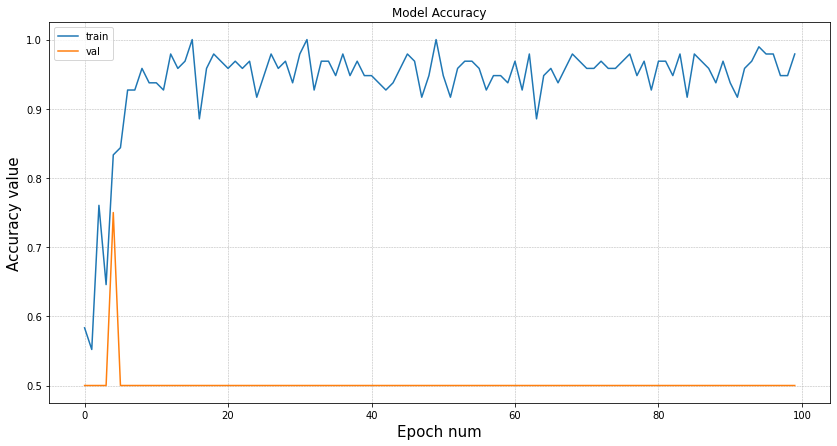

In [133]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

## Loss plots

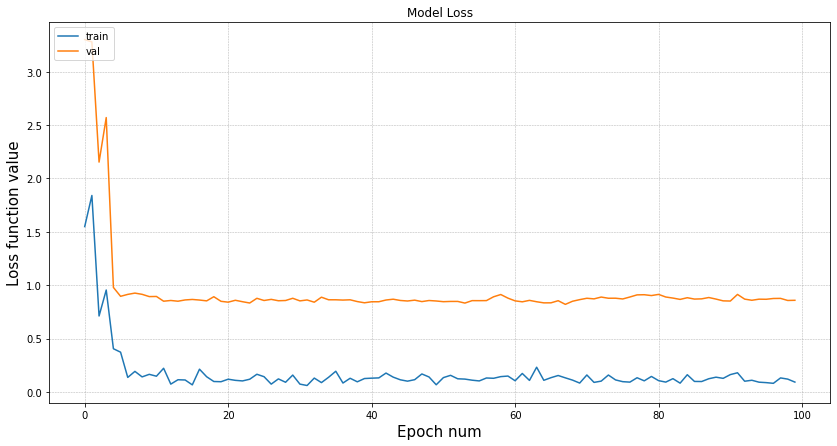

In [134]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss.keys():
    plt.plot(loss[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

In [135]:
#Костыль ImageFolder, который не может обработать путь к папке в которой уже сразу лежат изображения
#Копируем всю папку test в директорию test\unknown
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [136]:
#Мы не знаем, какие ID, какие названия изображения у нас генерируется, когда мы просим у DataLoader -- "дай нам следующий батч".
#Они по алфавиту идут, по дате создания, или просто случайным образом -- непонятно.
#Поэтому нам нужно переписать немножко ImageFolder, чтобы он нам отдавал не просто tuple, с самим изображением и его меткой, а ещё, чтобы он отдавал имя, ну, либо -- путь к изображению.
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test/', val_transforms_base)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [137]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [138]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 47/47 [00:06<00:00,  6.94it/s]


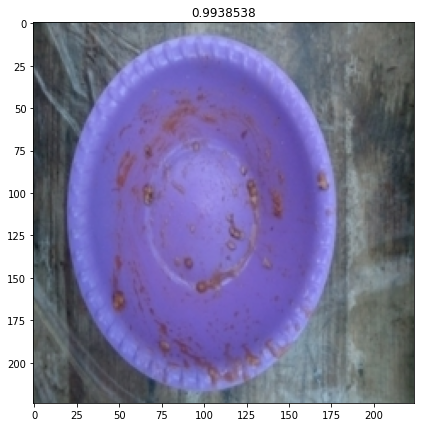

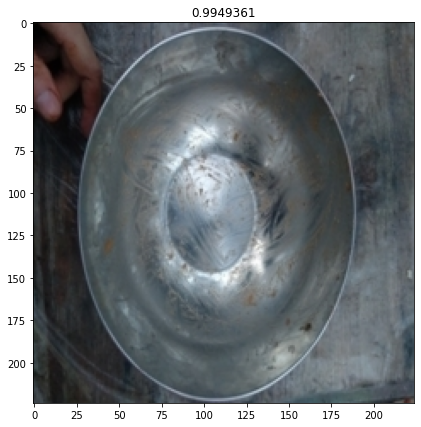

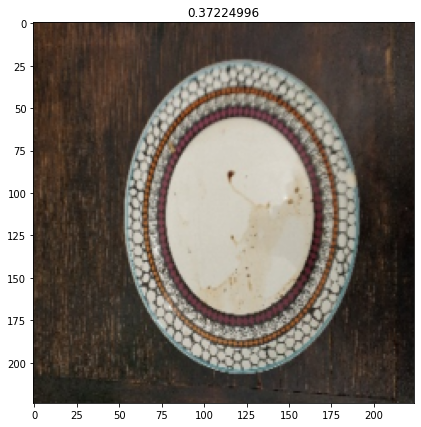

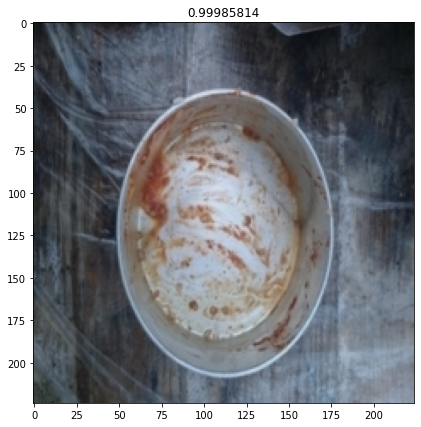

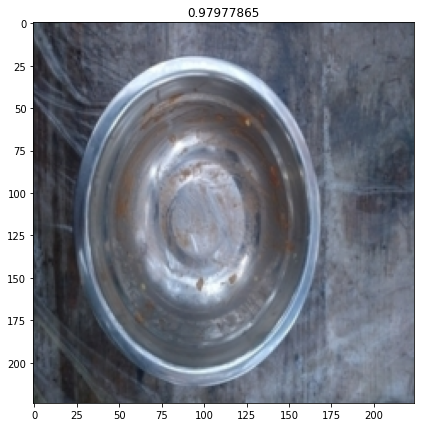

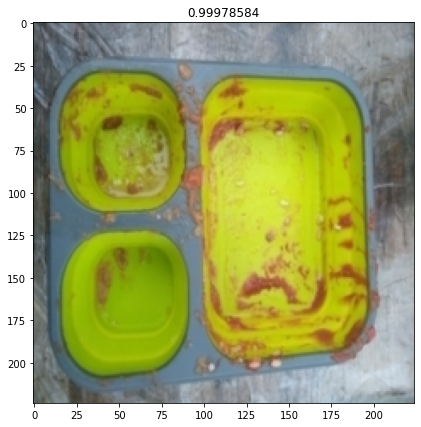

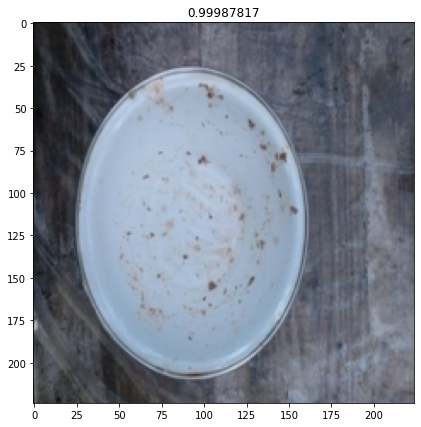

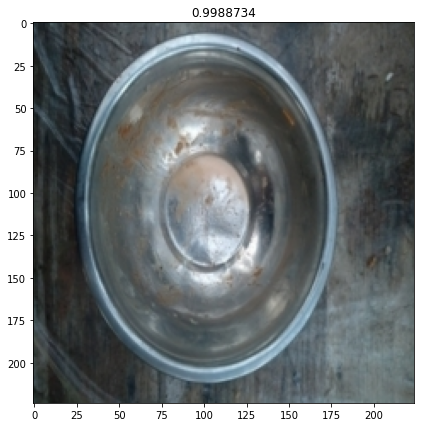

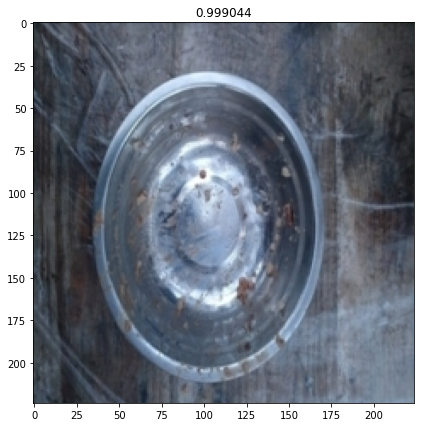

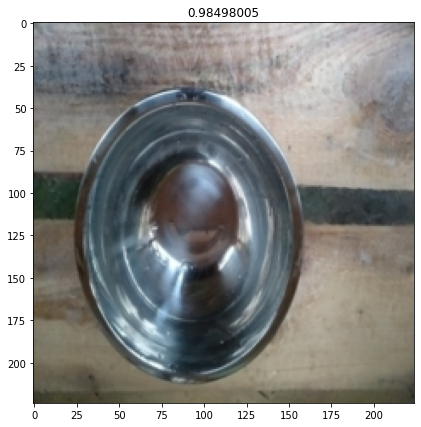

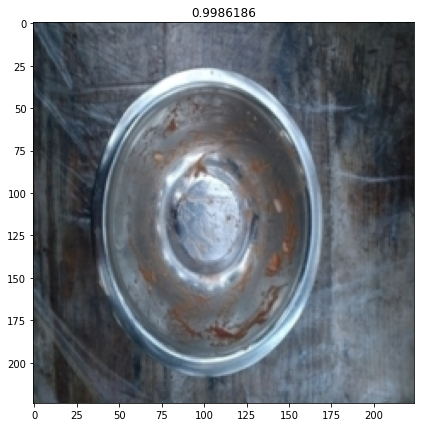

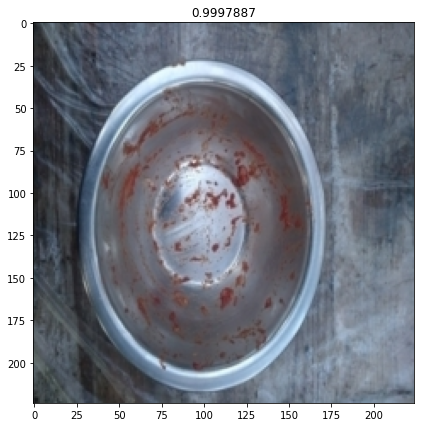

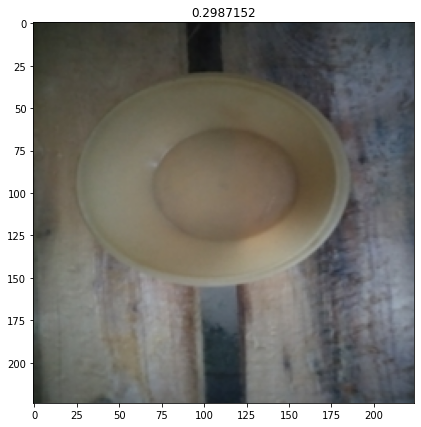

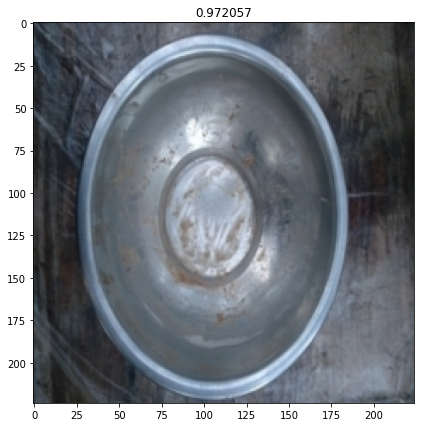

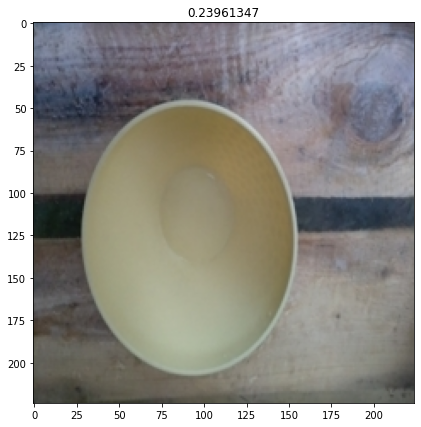

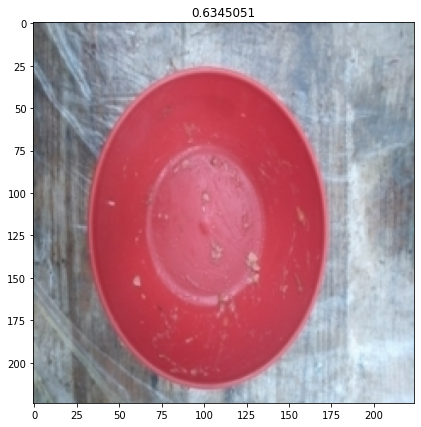

In [139]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [143]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [144]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.725 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id           
0000    dirty
0001    dirty
0002  cleaned
0003    dirty
0004    dirty
0005    dirty

## Save submission

In [146]:
submission_df.to_csv('submission.csv')

In [16]:
!rm -rf train val